# Final Project: San Francisco Bike Theft Predictions

# Part 1: Proposal
*Frame the problem, criteria, and data source(s)*

## Problem Statement

1. Hypothesis/assumptions
2. Goals and Success Metrics
3. Risk/Limitations
4. Data Source

**Stolen and not stolen bike data from the [Bikeindex API3](https://bikeindex.org/documentation/api_v3).**
- Data collected real time. 
- API scraped as of November 5, 2018.

**San Francisco City data from the [datasf.org](https://data.sfgov.org/City-Management-and-Ethics/San-Francisco-City-Survey-Data-1996-2017/huch-6k5m).**
- Data collected every two years. 
- Documentation recommends using data from 2015 forward.
- Most complete zipcode-related data is from 2017 survey.

For this project, I downloaded all the bike data in BikeIndex and merged San Francisco city data via zipcodes. The following lines of code document my method of cleaning the bike data and combine it with the San Francisco survey data in a meaningful way. Because the survey data for San Francisco was written as a set of classifiers, I used dummy variables to quantify this information into probabilities.

Bike retrieval code can be found at my [github here](https://github.com/chanwinyee/ds_foundations/blob/master/final_project/bike_index_data_retrieval_DONE.ipynb).


In [1]:
# Data cleaning, exploration, and analysis tools
import pandas as pd
import seaborn as sns
import numpy as np
from ast import literal_eval
import re as re


### Clean the BikeIndex data

In [2]:
# Import the csv of stolen and not stolen bike data and store in a pandas DataFrame
bike_data = pd.read_csv('bike_index_api_stolenessall.csv')
bike_df = pd.DataFrame(data=bike_data)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188574 entries, 0 to 188573
Data columns (total 14 columns):
Unnamed: 0           188574 non-null int64
date_stolen          62097 non-null float64
frame_colors         188574 non-null object
frame_model          170000 non-null object
id                   188574 non-null int64
is_stock_img         188574 non-null bool
large_img            78875 non-null object
manufacturer_name    188567 non-null object
serial               188211 non-null object
stolen               188574 non-null bool
stolen_location      61129 non-null object
thumb                78875 non-null object
title                188573 non-null object
year                 133836 non-null float64
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 17.6+ MB


In [3]:
bike_df.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year
0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN
1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN
2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN
3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0
4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0


This bike data has all datapoints ever collected in the BikeIndex API. What I really want are datapoints for bikes that are in San Francisco.

**Assumption 1:** I am going to narrow this data set's positive signal for stolen to bikes that have some representation of California as evident by a "stolen_location" value that contains "CA", "California", or "San Francisco" in it. I am including all data points that are NaN in stolen_location as that will be my signal for not stolen bikes.

In [4]:
bike_df_clean = bike_df.copy()
bike_df_clean = bike_df_clean[bike_df_clean['stolen_location'].apply(str).str.contains('CA|California|San Francisco|')]

In [5]:
# Confirm that there are both stolen and non-stolen datapoints
bike_df_clean['stolen'].value_counts()

False    126494
True      62080
Name: stolen, dtype: int64

In [6]:

def split_zipcode(x):
    array=re.findall('\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
bike_df_clean['stolen_zipcode'] = bike_df_clean['stolen_location'].apply(split_zipcode)

In [7]:
# Confirm that the zipcode dad has been successfully parsed out into a new column
bike_df_clean.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,None
1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,None
2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,None
3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,None
4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,None


In [8]:
# The size of the California dataset is much smaller than the original dataset
bike_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188574 entries, 0 to 188573
Data columns (total 15 columns):
Unnamed: 0           188574 non-null int64
date_stolen          62097 non-null float64
frame_colors         188574 non-null object
frame_model          170000 non-null object
id                   188574 non-null int64
is_stock_img         188574 non-null bool
large_img            78875 non-null object
manufacturer_name    188567 non-null object
serial               188211 non-null object
stolen               188574 non-null bool
stolen_location      61129 non-null object
thumb                78875 non-null object
title                188573 non-null object
year                 133836 non-null float64
stolen_zipcode       54772 non-null object
dtypes: bool(2), float64(2), int64(2), object(9)
memory usage: 20.5+ MB


In [9]:
# Convert the date_stolen into something readable and extract the year
bike_df_clean['date_stolen'] = pd.to_datetime(bike_df_clean['date_stolen'],unit='s')
bike_df_clean['year_stolen'] = bike_df_clean['date_stolen'].dt.year

In [10]:
# Confirm that the year has been extracted correctly.
bike_df_clean

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode,year_stolen
0,0,NaT,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,None,NaN
1,1,NaT,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,None,NaN
2,2,NaT,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,None,NaN
3,3,NaT,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,None,NaN
4,4,NaT,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,None,NaN
5,5,NaT,['Green'],Volpe,355566,False,NaN,Bianchi,8309,False,NaN,NaN,2006 Bianchi Volpe,2006.0,None,NaN
6,6,NaT,['Blue'],Kirsten,120716,False,NaN,Klein Bikes,absent,False,NaN,NaN,1988 Klein Bikes Kirsten,1988.0,None,NaN
7,7,NaT,['Yellow or Gold'],NaN,366387,False,NaN,SE Racing,8=1F61210744,False,NaN,NaN,SE Racing,NaN,None,NaN
8,8,NaT,['Black'],xmr,355559,False,NaN,motorino xmr,882016052388493,False,NaN,NaN,2017 motorino xmr xmr,2017.0,None,NaN
9,9,NaT,"['White', 'Blue']",Gran Fondo 1.3 C,392894,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Fuji,FJ151CJ00265,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2013 Fuji Gran Fondo 1.3 C,2013.0,None,NaN


In [11]:
# Check to see if the data is clean for year, as in, there are no repeat years or strange ways to notate the year
year_stolen = []
year_stolen = bike_df_clean['year_stolen'].unique()
year_stolen.sort()
year_stolen

array([1970., 1971., 1972., 1979., 1985., 1986., 1990., 1994., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018.,   nan])

**Assumption 2:** Knowing that my San Francisco City Survey Data recommends only using the data from 2015 forward and the most complete data is from the survey conducted in 2017, I am going to base my model on bike data from 2015 forward and assume that the state of San Francisco between 2015 and present day is not much different than what was captured in 2017.

Looking at the completeness of the BikeIndex dataset, it appears the data is richer in the years after 2014.

In [12]:
bike_df_clean.groupby('year_stolen').count()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
year_stolen,,,,,,,,,,,,,,,
1970.0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,0
1971.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1972.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1979.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1985.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1
1986.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1
1990.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1994.0,3,3,3,3,3,3,0,3,3,3,3,0,3,3,3
1996.0,2,2,2,2,2,2,0,2,2,2,2,0,2,2,1


In [13]:
# Select data from year_stolen 2015 to 2018
bike_df_final = bike_df_clean[bike_df_clean['year_stolen'].isin(['2018','2017','2016','2015',None])]
bike_df_final['year_stolen'].unique()

array([  nan, 2017., 2018., 2016., 2015.])

In [14]:
bike_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161992 entries, 0 to 188573
Data columns (total 16 columns):
Unnamed: 0           161992 non-null int64
date_stolen          35515 non-null datetime64[ns]
frame_colors         161992 non-null object
frame_model          145268 non-null object
id                   161992 non-null int64
is_stock_img         161992 non-null bool
large_img            67245 non-null object
manufacturer_name    161985 non-null object
serial               161629 non-null object
stolen               161992 non-null bool
stolen_location      34830 non-null object
thumb                67245 non-null object
title                161991 non-null object
year                 111914 non-null float64
stolen_zipcode       29988 non-null object
year_stolen          35515 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 18.8+ MB


In [15]:
# Store final data into csv
bike_df_final.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/bike_data_clean.csv')

### Cleaning the San Francisco Survey Data

In [16]:
# Import the survey data
survey_data = pd.read_csv('San_Francisco_City_Survey_Data_1996-2017.csv')
survey_df = pd.DataFrame(data=survey_data)
total_columns = survey_df.columns
print(len(total_columns))
print(survey_df.columns.nunique())

92
92


Seeing there are 92 columns in this survey dataset, I read through the Survey data dictionary to understand what was available to me and selected columns that could be relevant to zipcodes where bikes are stolen. 

**Assumption 3:** I selected columns that are organized, according to the data dictionary, into "survey" and "demographics". I made the assumption that demographics of a zipcode are variables that can predict whether or not a bike will get stolen.

In [17]:
# Data Dictionary for survey data
column_names = {
    'id':'Unique id',
    'year':'Survey year',
    'mode':'survey mode',
    'language':'survey language',
    'dlivedsf':'Length of SF residence 1996-2009 (Groupings change in 2011)', #Made Contiguous 
    'primlang_1':'primary language 1',
    'primlang_2':'primary language',
    'primlang_3':'primary language',
    'primlang_4':'primary_language',
    'dage':'Respondents age group (Age groups change in 2011, 2017)', #Made Contiguous 
    'dethnic':'Respondents ethnicity',
    'mixed_1':'mixed race or ethnics',
    'mixed_2':'mixed race or ethnics',
    'mixed_3':'mixed race or ethnics',
    'mixed_4':'mixed race or ethnics',
    'deduc':'Respondents highest education completed',
    'dincome':'Household income year prior to survey', #Made Contiguous 
    'dhouse':'Number of people in household', #Made Contiguous 
    'ownrenhm':'Own or rent home',
    'gender':'Respondents sex',
    'dsexornt':'Respondents sexual orientation',
    'zipcode':'zipcode',
    'district':'Supervisorial District',
    'movesf':'Likelihood of moving away from SF in the next 3 years',
    'disablephys':'physically disabled',
    'disablement':'mentally disabled'    
}

After looking at the demographic data, I noticed that there are fields that may not relate to bike-stolenness.

**Assumption 4:** Mentally disabled or physically disabled persons are less likely to ride bikes. I removed this column for consideration in my model.

**Assumption 5:** Survey year, mode, survey language, years lived in San Francisco, age, ethnicity, education, income, number of people in household, gender, and likelihood of moving away from SF are variables to consider in likelihood to have a bike stolen.

**Assumption 6:** When making values contiguous, I assigned the upper bound of the following columns to be:

- dlivedsf: 30+ changed to 40; years lived in SF
- dage: 65+ changed to 65; age
- dincome: 200001+ changed to 300000; income
- dhouse: 6 or more changed to 6; number of people in household

In [18]:
# Collect an array of column titles to keep

survey_info = ['year'] # Columns classified as survey-related
demographics = ['dlivedsf','dage','dethnic','deduc','dincome','dhouse','gender','zipcode','movesf'] # Columns classified as demographics-related
active_columns = survey_info + demographics

# Collect an array of column titles to discard
discard_columns = []

for t in total_columns:
    if t not in active_columns:
        discard_columns.append(t)
        
# Create clean DataFrame with relevant survey columns( active_columns)

survey_df_clean = survey_df.copy()
survey_df_clean = survey_df_clean.drop(columns=discard_columns)
survey_df_clean = survey_df_clean[survey_df_clean['year'].isin(['2018','2017','2016','2015'])]


In [19]:
survey_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4345 entries, 16699 to 37971
Data columns (total 10 columns):
year        4345 non-null int64
dhouse      4345 non-null float64
dlivedsf    4345 non-null float64
movesf      4345 non-null float64
dincome     4345 non-null float64
dage        4345 non-null float64
gender      4345 non-null float64
dethnic     4345 non-null float64
deduc       4345 non-null float64
zipcode     2166 non-null float64
dtypes: float64(9), int64(1)
memory usage: 373.4 KB


Because I am planning to merge the survey data with my bike data using zipcodes, any data that does not have a zipcode to link is unusable. I am discarding all survey data that has a missing zipcode.

In [20]:
# Drop null zipcodes
survey_df_clean_null = survey_df_clean[survey_df_clean.isnull().any(axis=1)]
survey_df_clean_value = survey_df_clean.copy()
survey_df_clean_value = survey_df_clean_value.dropna()

In [21]:
print('Years of survey with null zipcodes: ',survey_df_clean_null['year'].unique())
print('Years of survey with zipcodes: ',survey_df_clean_value['year'].unique())

Years of survey with null zipcodes:  [2015]
Years of survey with zipcodes:  [2017]


The survey data with zipcodes on which I can merge to my BikeIndex dataset is from 2017. (See **Assumption 2**)

In [22]:
# Check data size. Appears deceptively complete. 
survey_df_clean_value.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 16699 to 37971
Data columns (total 10 columns):
year        2166 non-null int64
dhouse      2166 non-null float64
dlivedsf    2166 non-null float64
movesf      2166 non-null float64
dincome     2166 non-null float64
dage        2166 non-null float64
gender      2166 non-null float64
dethnic     2166 non-null float64
deduc       2166 non-null float64
zipcode     2166 non-null float64
dtypes: float64(9), int64(1)
memory usage: 186.1 KB


In [23]:
# Manually type in the survey and demographics key into dictionaries
# Note any "not available" datapoints as NaN
# Convert columns that can be contiguous

#Made Contiguous
dlivedsf_dict={
    1:2,
    2:5,
    3:10,
    4:20,
    5:30,
    6:40, #30+; I gave this value an extra subjective weight
    7:None
}

# Made contiguous
dage_dict={
    1:24,
    2:34,
    3:44,
    4:54,
    5:59,
    6:64,
    7:65, #65+
    8:None
}

dethnic_dict={
    1:'Black/African American',
    2:'Asian or Pacific Islander',
    3:'Latino/Hispanic',
    4:'Native American/Indian',
    5:'White/Caucasian',
    6:'Other',
    7:'Mixed Ethnicity',
    8:'Dont know',
    9:None,
    10:'Pacific Islander',
    11:'Arab / Middle Eastern /North African ( 2015 Only); Arab,Middle Eastern, South Asian (2017)',
    12:'Mixed Unspecified',
    13:'Caribbean (2017)'
}

deduc_dict={
    1:'Less than high school',
    2:'High school',
    3:'Less than 4 years of college',
    4:'4 or more years of college/Post Graduate',
    5:None,
}

# Made contiguous
dincome_dict={
    1:10000,
    2:25000,
    3:35000,
    4:50000,
    5:100000,
    6:200000,
    7:300000, #30000 +
    8:None
}

# Made contiguous
dhouse_dict={
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6, #6 ore more
    7:None,
}

gender_dict={
    1:'Female',
    2:'Male',
    3:'Other',
    4:None,
}

movesf_dict={
    1:'Very likely',
    2:'Somewhat likely',
    3:'Not too likely',
    4:'Not at all likely',
    5:None
}

In [24]:
survey_df_clean_value.head()

,year,dhouse,dlivedsf,movesf,dincome,dage,gender,dethnic,deduc,zipcode
16699,2017,1.0,3.0,2.0,2.0,2.0,1.0,2.0,2.0,94114.0
18495,2017,2.0,6.0,4.0,7.0,7.0,2.0,5.0,4.0,94124.0
18885,2017,2.0,6.0,4.0,3.0,4.0,2.0,1.0,3.0,94115.0
20949,2017,2.0,4.0,2.0,6.0,3.0,1.0,4.0,4.0,94110.0
29172,2017,2.0,3.0,4.0,8.0,4.0,1.0,9.0,4.0,94132.0


In [25]:
# Apply dictionary to dataset
survey_df_clean_value_a= survey_df_clean_value.copy()
survey_df_clean_value_a['dhouse'] = survey_df_clean_value_a['dhouse'].map(dhouse_dict)
survey_df_clean_value_a['dlivedsf'] = survey_df_clean_value_a['dlivedsf'].map(dlivedsf_dict)
survey_df_clean_value_a['movesf'] = survey_df_clean_value_a['movesf'].map(movesf_dict)
survey_df_clean_value_a['dincome'] = survey_df_clean_value_a['dincome'].map(dincome_dict)
survey_df_clean_value_a['dage'] = survey_df_clean_value_a['dage'].map(dage_dict)
survey_df_clean_value_a['gender'] = survey_df_clean_value_a['gender'].map(gender_dict)
survey_df_clean_value_a['dethnic'] = survey_df_clean_value_a['dethnic'].map(dethnic_dict)
survey_df_clean_value_a['deduc'] = survey_df_clean_value_a['deduc'].map(deduc_dict)

survey_df_clean_value_a.head()

,year,dhouse,dlivedsf,movesf,dincome,dage,gender,dethnic,deduc,zipcode
16699,2017,1.0,10.0,Somewhat likely,25000.0,34.0,Female,Asian or Pacific Islander,High school,94114.0
18495,2017,2.0,40.0,Not at all likely,300000.0,65.0,Male,White/Caucasian,4 or more years of college/Post Graduate,94124.0
18885,2017,2.0,40.0,Not at all likely,35000.0,54.0,Male,Black/African American,Less than 4 years of college,94115.0
20949,2017,2.0,20.0,Somewhat likely,200000.0,44.0,Female,Native American/Indian,4 or more years of college/Post Graduate,94110.0
29172,2017,2.0,10.0,Not at all likely,NaN,54.0,Female,None,4 or more years of college/Post Graduate,94132.0


In [26]:
# Check to see that NaN values are accurately recorded
survey_df_clean_value_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 16699 to 37971
Data columns (total 10 columns):
year        2166 non-null int64
dhouse      2145 non-null float64
dlivedsf    2159 non-null float64
movesf      2137 non-null object
dincome     1781 non-null float64
dage        2113 non-null float64
gender      2133 non-null object
dethnic     2066 non-null object
deduc       2124 non-null object
zipcode     2166 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 186.1+ KB


In [27]:
# Use DummyVariables to quantify qualitative data into probabilities

survey_df_clean_value_a_dummies = pd.get_dummies(survey_df_clean_value_a)
survey_df_final = survey_df_clean_value_a_dummies.copy()
survey_df_final = survey_df_final.groupby('zipcode').mean()

survey_df_final.head()

,year,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,movesf_Not too likely,movesf_Somewhat likely,movesf_Very likely,gender_Female,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
zipcode,,,,,,,,,,,,,,,,,,,,,
94102.0,2017,2.246914,22.951220,77323.943662,48.691358,0.500000,0.182927,0.170732,0.134146,0.585366,...,0.000000,0.024390,0.378049,0.0,0.097561,0.109756,0.414634,0.243902,0.231707,0.085366
94103.0,2017,2.294872,21.076923,111805.555556,48.423077,0.474359,0.217949,0.141026,0.166667,0.628205,...,0.025641,0.000000,0.435897,0.0,0.102564,0.205128,0.538462,0.179487,0.256410,0.025641
94104.0,2017,2.545455,10.727273,113500.000000,40.250000,0.250000,0.250000,0.250000,0.166667,0.750000,...,0.083333,0.000000,0.333333,0.0,0.000000,0.250000,0.583333,0.333333,0.000000,0.083333
94105.0,2017,1.944444,14.555556,189666.666667,45.833333,0.444444,0.222222,0.111111,0.222222,0.611111,...,0.055556,0.000000,0.500000,0.0,0.055556,0.000000,0.944444,0.055556,0.000000,0.000000
94107.0,2017,2.392157,26.450980,156914.893617,50.620000,0.568627,0.156863,0.176471,0.098039,0.529412,...,0.019608,0.019608,0.588235,0.0,0.078431,0.058824,0.647059,0.117647,0.196078,0.039216


In [28]:
# Store as a CSV
survey_df_final.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/survey_clean_2017.csv')

### Combine the BikeIndex data with San Francisco City Survey Data

In [29]:
# Import CSVs

bike_df = pd.read_csv('bike_data_clean.csv')
bike_df = pd.DataFrame(data=bike_df)

survey_df = pd.read_csv('survey_clean_2017.csv')
survey_df = pd.DataFrame(data=survey_df)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,7,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
bike_df.head()

,Unnamed: 0,Unnamed: 0.1,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode,year_stolen
0,0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,NaN,NaN
1,1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,NaN,NaN
2,2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,NaN,NaN
3,3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,NaN,NaN
4,4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,NaN,NaN


In [31]:
survey_df.head()

,zipcode,year,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,movesf_Not too likely,movesf_Somewhat likely,movesf_Very likely,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
0,94102.0,2017,2.246914,22.951220,77323.943662,48.691358,0.500000,0.182927,0.170732,0.134146,...,0.000000,0.024390,0.378049,0.0,0.097561,0.109756,0.414634,0.243902,0.231707,0.085366
1,94103.0,2017,2.294872,21.076923,111805.555556,48.423077,0.474359,0.217949,0.141026,0.166667,...,0.025641,0.000000,0.435897,0.0,0.102564,0.205128,0.538462,0.179487,0.256410,0.025641
2,94104.0,2017,2.545455,10.727273,113500.000000,40.250000,0.250000,0.250000,0.250000,0.166667,...,0.083333,0.000000,0.333333,0.0,0.000000,0.250000,0.583333,0.333333,0.000000,0.083333
3,94105.0,2017,1.944444,14.555556,189666.666667,45.833333,0.444444,0.222222,0.111111,0.222222,...,0.055556,0.000000,0.500000,0.0,0.055556,0.000000,0.944444,0.055556,0.000000,0.000000
4,94107.0,2017,2.392157,26.450980,156914.893617,50.620000,0.568627,0.156863,0.176471,0.098039,...,0.019608,0.019608,0.588235,0.0,0.078431,0.058824,0.647059,0.117647,0.196078,0.039216


**Assumption 7:** Only bikes that are stolen will have zipcode data as that is where the crime occurred. I will be holding onto NaN zipcode values.

In [32]:
# Merge datasets on stolen_zipcode == zipcode; drop bikes stolen that do not have zipcode
bikedata_df = pd.merge(bike_df, survey_df,how='left', right_on = 'zipcode', left_on = 'stolen_zipcode')
bikedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161992 entries, 0 to 161991
Data columns (total 43 columns):
Unnamed: 0                                        161992 non-null int64
Unnamed: 0.1                                      161992 non-null int64
date_stolen                                       35515 non-null object
frame_colors                                      161992 non-null object
frame_model                                       145268 non-null object
id                                                161992 non-null int64
is_stock_img                                      161992 non-null bool
large_img                                         67245 non-null object
manufacturer_name                                 161985 non-null object
serial                                            161629 non-null object
stolen                                            161992 non-null bool
stolen_location                                   34830 non-null object
thumb                  

In [33]:
# Remove extraneous columns
inactive_columns=['Unnamed: 0','Unnamed: 0.1','id','is_stock_img','large_img','serial','stolen_location','thumb','title','year_x','stolen_zipcode', 'zipcode','year_y','frame_model']
bikedata_df = bikedata_df.drop(columns=inactive_columns)

**Limitation 1:** I only have zipcode data for bikes that are stolen. Bikes that are not stolen may need other variables and attributes for my model to predict.

I am going forward with cleaning the manufacturer and bike colour data.

# Part 2: Brief
*Perform EDA on the dataset*

## Exploratory Data Summary
1. Create an exploratory data analysis notebook.
2. Perform statistical analysis, along with any visualizations.
3. Determine how to handle sampling or missing values.
4. Clearly identify shortcomings, assumptions, and next steps.


In [34]:
# Data cleaning, exploration, and analysis tools
import pandas as pd
import seaborn as sns
import numpy as np
from ast import literal_eval
import re as re
from matplotlib import pyplot
import scipy.stats as stats

%matplotlib inline

In [35]:
# Take a look at the distribution of manufacturer names and identify the most commonly used manufacturers
bikedata_df['manufacturer_name'].nunique()

4238

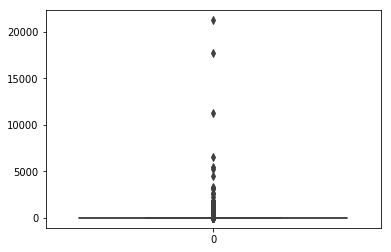

In [36]:
sns.boxplot( data=bikedata_df['manufacturer_name'].value_counts())

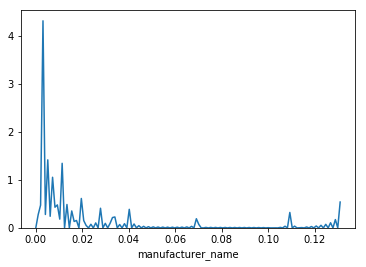

In [37]:
sns.distplot(bikedata_df['manufacturer_name'].value_counts(sort=True,ascending=False, normalize=True), hist=False)

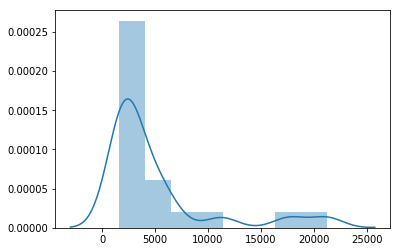

In [38]:
manufacturer_df = pd.DataFrame(data=bikedata_df['manufacturer_name'].value_counts())
sns.distplot(manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500])

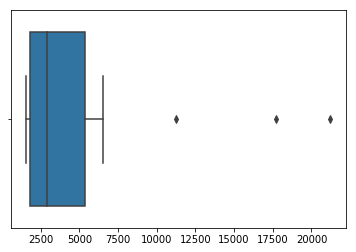

In [39]:
sns.boxplot(manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500])

In [40]:
manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500]

,manufacturer_name
Specialized,21216
Trek,17695
Giant,11260
Cannondale,6510
Schwinn,5466
Fuji,5302
Raleigh,4509
Jamis,3314
Diamondback,3219
Kona,3158


In [41]:
manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500].nunique()

manufacturer_name    20
dtype: int64

In [42]:
# Clean data to anonymize bike brands outside of popular bike brands

bike_brands = ['Specialized','Trek','Giant','Cannondale','Schwinn','Fuji','Raleigh','Jamis','Diamondback', 'Kona','Surly','Bianchi','Marin Bikes','Electra','GT Bicycles','SCOTT','Felt','Novara','KHS Bicycles','Mission Bicycles']
bikedata_df.loc[~bikedata_df['manufacturer_name'].isin(bike_brands), 'manufacturer_name'] = 'Other'

In [43]:
bikedata_df.head(10)

,date_stolen,frame_colors,manufacturer_name,stolen,year_stolen,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
0,NaN,['Green'],Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,['Black'],KHS Bicycles,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"['Silver, gray or bare metal']",Kona,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,['Blue'],Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,"['Silver, gray or bare metal']",Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,['Green'],Bianchi,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,['Blue'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,['Yellow or Gold'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,['Black'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,"['White', 'Blue']",Fuji,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
bikedata_df['manufacturer_name'].value_counts(normalize=True)

Other               0.374741
Specialized         0.130969
Trek                0.109234
Giant               0.069510
Cannondale          0.040187
Schwinn             0.033742
Fuji                0.032730
Raleigh             0.027835
Jamis               0.020458
Diamondback         0.019871
Kona                0.019495
Surly               0.016680
Bianchi             0.015698
Marin Bikes         0.013723
Electra             0.011402
GT Bicycles         0.011297
SCOTT               0.011044
Felt                0.011031
Novara              0.010784
KHS Bicycles        0.010050
Mission Bicycles    0.009519
Name: manufacturer_name, dtype: float64

In [45]:
bikedata_df['manufacturer_name'].groupby(bikedata_df['stolen']).value_counts(normalize=True)

stolen  manufacturer_name
False   Other                0.386960
        Specialized          0.132273
        Trek                 0.100156
        Giant                0.069232
        Cannondale           0.035557
        Schwinn              0.033153
        Fuji                 0.032276
        Raleigh              0.027452
        Jamis                0.021016
        Kona                 0.019348
        Diamondback          0.018684
        Surly                0.017711
        Bianchi              0.015126
        Marin Bikes          0.014240
        Electra              0.012358
        Mission Bicycles     0.011813
        KHS Bicycles         0.011220
        Felt                 0.010967
        SCOTT                0.010413
        GT Bicycles          0.010231
        Novara               0.009812
True    Other                0.331231
        Trek                 0.141558
        Specialized          0.126327
        Giant                0.070497
        Cannondale      

**Assumption 8:** Of the 4238 manufacturers in this dataset, I defined a significant manufacturer by a threshold of 1500 bikes registered. Otherwise, I will classify them as "other". There are 20 manufacturers to note in the dataset. These 20 manufacturers represent 62.53% of the total dataset, 61.3% of non-stolen bikes, and 66.88% of stolen bikes.

In [46]:
# Explore the distribution of bike colours and identify the most commonly used colour descriptions
bikedata_df['frame_colors'].nunique()

802

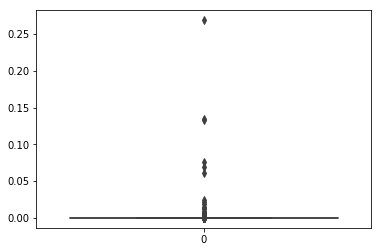

In [47]:
sns.boxplot( data=bikedata_df['frame_colors'].value_counts(normalize=True))

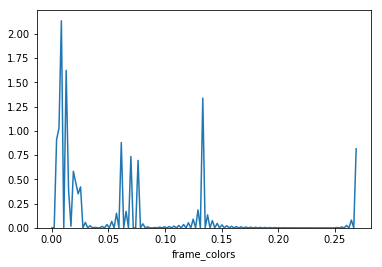

In [48]:
sns.distplot(bikedata_df['frame_colors'].value_counts(sort=True,ascending=True, normalize=True), hist=False)

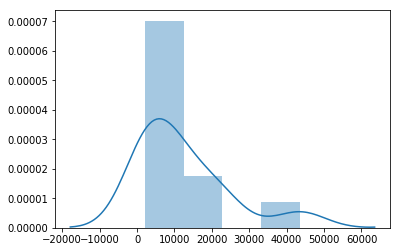

In [49]:
colors_df = pd.DataFrame(data=bikedata_df['frame_colors'].value_counts())
sns.distplot(colors_df.loc[colors_df['frame_colors']>2000])

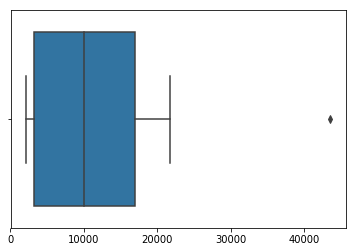

In [50]:
sns.boxplot(colors_df.loc[colors_df['frame_colors']>2000])

In [51]:
colors_df.loc[colors_df['frame_colors']>2000]

,frame_colors
['Black'],43552
"['Silver, gray or bare metal']",21736
['Blue'],21569
['White'],12389
['Red'],11255
['Green'],9973
['Orange'],3957
['Purple'],3503
['Yellow or Gold'],3046
['Teal'],2326


In [52]:
colors_df.loc[colors_df['frame_colors']>2000].count()

frame_colors    11
dtype: int64

In [53]:
#bike_color = ["['Black']","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Orange']","['Purple']","['Yellow or Gold']","['Teal']","['Brown']","['Black', 'Red']","['Pink']","['Black', 'Blue']","['Black', 'Green']"]
bike_color = ["['Black']","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Orange']","['Purple']","['Yellow or Gold']","['Teal']","['Brown']"]
bikedata_df.loc[~bikedata_df['frame_colors'].isin(bike_color), 'frame_colors'] = 'Other'

In [54]:
bikedata_df['frame_colors'].value_counts(normalize=True)

['Black']                         0.268853
Other                             0.163946
['Silver, gray or bare metal']    0.134179
['Blue']                          0.133149
['White']                         0.076479
['Red']                           0.069479
['Green']                         0.061565
['Orange']                        0.024427
['Purple']                        0.021625
['Yellow or Gold']                0.018803
['Teal']                          0.014359
['Brown']                         0.013136
Name: frame_colors, dtype: float64

In [55]:
bikedata_df['frame_colors'].groupby(bikedata_df['stolen']).value_counts(normalize=True)

stolen  frame_colors                  
False   ['Black']                         0.274406
        Other                             0.147707
        ['Blue']                          0.138425
        ['Silver, gray or bare metal']    0.135729
        ['White']                         0.075376
        ['Red']                           0.070537
        ['Green']                         0.064211
        ['Orange']                        0.024614
        ['Purple']                        0.022606
        ['Yellow or Gold']                0.018858
        ['Teal']                          0.014367
        ['Brown']                         0.013165
True    ['Black']                         0.249078
        Other                             0.221769
        ['Silver, gray or bare metal']    0.128664
        ['Blue']                          0.114361
        ['White']                         0.080408
        ['Red']                           0.065711
        ['Green']                         0

**Assumption 8:** Of the 802 frame colours in this dataset, I defined a significant frame colour by a threshold of 2000 bikes registered. Otherwise, I will classify them as "Other". There are 12 frame colours to note in the dataset. These 12 frame colours represent 83.61% of the total dataset, 85.23% of non-stolen bikes, and 77.82% of stolen bikes.

In [56]:
bikedata_df.columns

Index(['date_stolen', 'frame_colors', 'manufacturer_name', 'stolen',
       'year_stolen', 'dhouse', 'dlivedsf', 'dincome', 'dage',
       'movesf_Not at all likely', 'movesf_Not too likely',
       'movesf_Somewhat likely', 'movesf_Very likely', 'gender_Female',
       'gender_Male', 'gender_Other', 'dethnic_Asian or Pacific Islander',
       'dethnic_Black/African American', 'dethnic_Dont know',
       'dethnic_Latino/Hispanic', 'dethnic_Mixed Ethnicity',
       'dethnic_Native American/Indian', 'dethnic_Other',
       'dethnic_Pacific Islander', 'dethnic_White/Caucasian',
       'deduc_4 or more years of college/Post Graduate', 'deduc_High school',
       'deduc_Less than 4 years of college', 'deduc_Less than high school'],
      dtype='object')

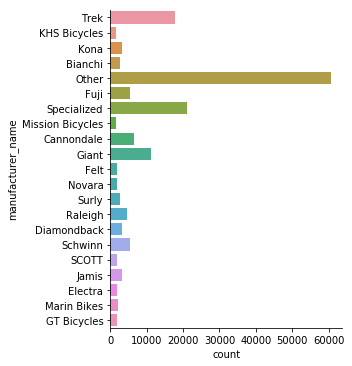

In [57]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df)

Most common bikes in the dataset are: Specialized, Trek, Giant, Fuji, Schwinn

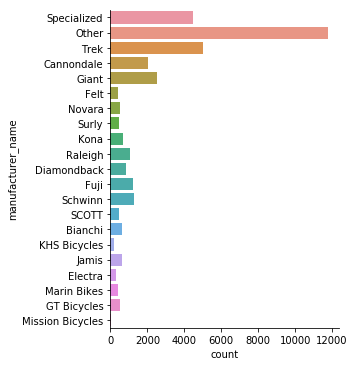

In [58]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df.loc[bikedata_df['stolen']==True])

Most common stolen bike brands are: Trek, Specialized, Giant, Cannondale.

Interesting that Cannondale stands out in the stolen data.

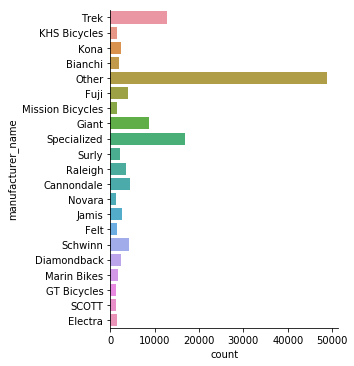

In [59]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df.loc[bikedata_df['stolen']==False])

Most common bikes not stolen are: Trek, Specialized, Giant, Raleigh, Cannondale, Schwinn, Fuji.

Although these observations are a bit biased as this reflects moreover bike popularity for purchase rather than likelihood to be stolen.

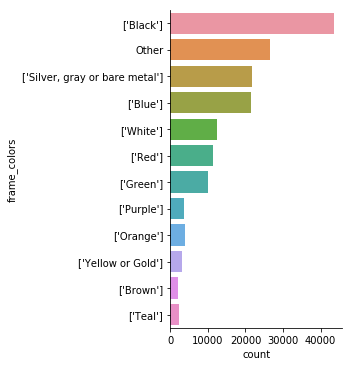

In [60]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df,
            order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

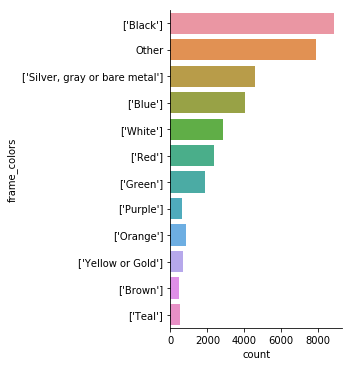

In [61]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df.loc[bikedata_df['stolen']==True],
           order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

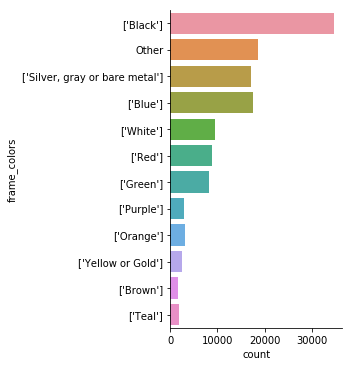

In [62]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df.loc[bikedata_df['stolen']==False],
           order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

Looking at stolen bike data alone for relationships

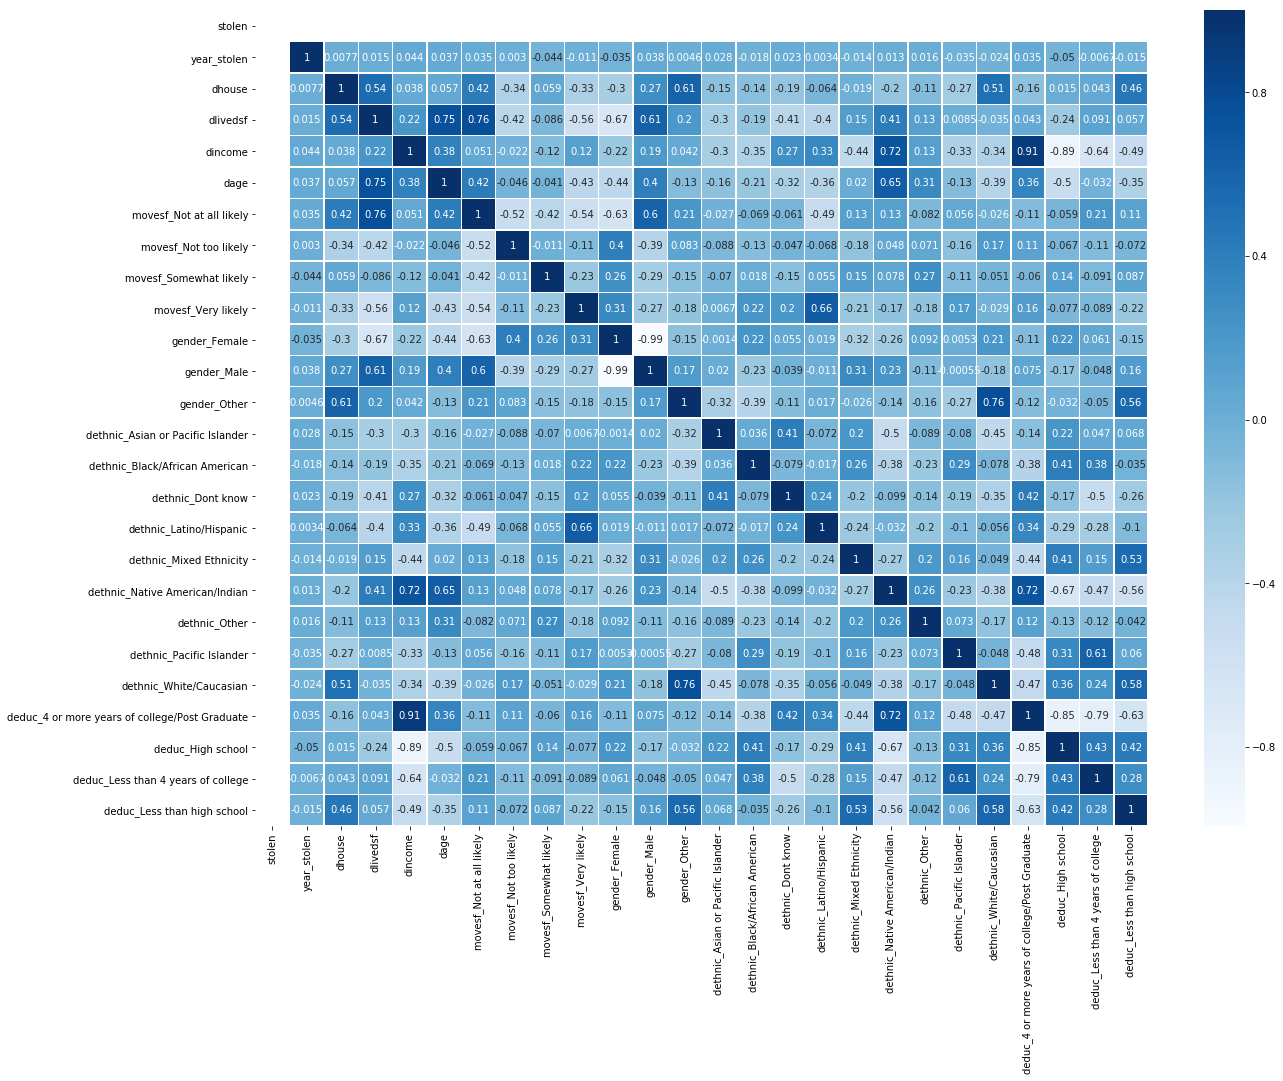

In [63]:
fig, ax = pyplot.subplots(figsize=(20,15))         # Sample figsize in inches

sns.heatmap(bikedata_df.loc[bikedata_df['stolen']==True].corr(),ax=ax,annot=True,linewidths=.5,cmap="Blues")

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


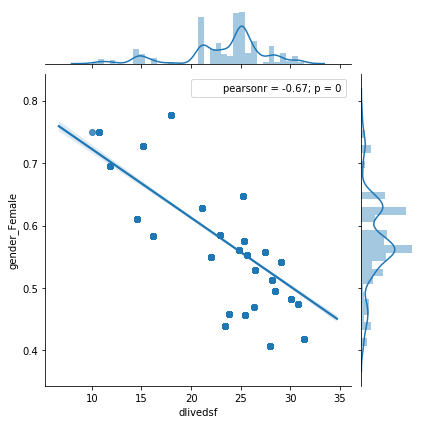

In [64]:
graph = sns.jointplot(y='gender_Female',x='dlivedsf',data=bikedata_df,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


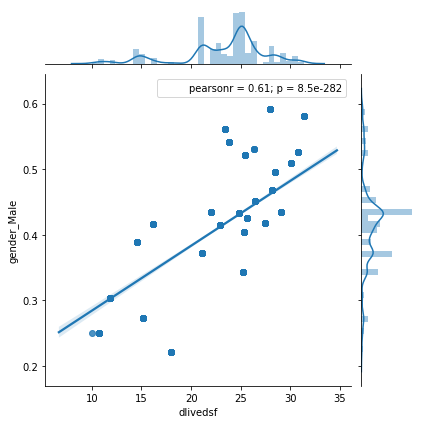

In [65]:
graph = sns.jointplot(y='gender_Male',x='dlivedsf',data=bikedata_df,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

If a bike has been stolen, it is less likely that area has more tenured female residents. However, it is more likely that that zipcode has more tenured male residents.

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


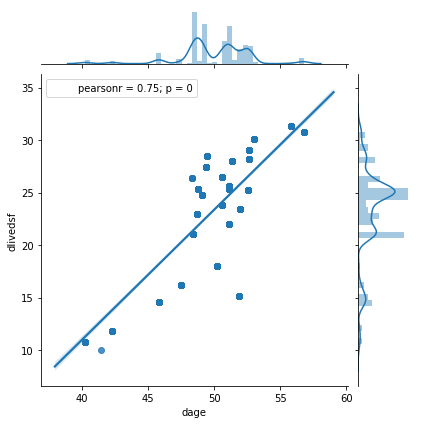

In [66]:
graph = sns.jointplot(y='dlivedsf',x='dage',data=bikedata_df,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

# Part 3: Technical Notebook

*A detailed Jupyter Notebook with a summary of your analysis, approach, and evaluation metrics.*

Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

In [67]:
# Import the Machine Learning Libraries

# Data cleaning for machine learning models
from sklearn.model_selection import train_test_split #split data into testing and training data
from sklearn.feature_selection import SelectKBest # identify best X that may predict Y
from sklearn.feature_selection import mutual_info_regression #needed for SelectKBest
from sklearn.preprocessing import StandardScaler #handle outliers after selecting K best guess variables that predict Y

# Machine Learning model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
#reg = LinearRegression(fit_intercept=True)
#fit_intercept = True; hyper parameter for linear regression, add one-extra term - a start value (a starting weight); rarely False



# Error Measures
from sklearn.dummy import DummyRegressor
# Use DummyRegressor to compare your linear regression to the dumbest possible

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [68]:
bikedata_ml=bikedata_df.copy()

In [69]:
bikedata_ml=pd.get_dummies(bikedata_ml,columns=['stolen','manufacturer_name','frame_colors'])

In [70]:
bikedata_ml.head().T

,0,1,2,3,4
date_stolen,NaN,NaN,NaN,NaN,NaN
year_stolen,NaN,NaN,NaN,NaN,NaN
dhouse,NaN,NaN,NaN,NaN,NaN
dlivedsf,NaN,NaN,NaN,NaN,NaN
dincome,NaN,NaN,NaN,NaN,NaN
dage,NaN,NaN,NaN,NaN,NaN
movesf_Not at all likely,NaN,NaN,NaN,NaN,NaN
movesf_Not too likely,NaN,NaN,NaN,NaN,NaN
movesf_Somewhat likely,NaN,NaN,NaN,NaN,NaN
movesf_Very likely,NaN,NaN,NaN,NaN,NaN
